# PCA

**References:**
- https://365datascience.com/tutorials/python-tutorials/pca-k-means/
- https://www.datacamp.com/tutorial/introduction-t-sne
- https://www.geeksforgeeks.org/difference-between-pca-vs-t-sne/

The contents of this notebook only clusters both **benign & malicious** samples.

**Objectives**
- To reduce dimensionality of the dataset.
- To obtain optimum number of features whilst retaining dataset's context and value.


## 1. Import Data

In [1]:
# Import Libraries
import pandas as pd
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA, TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

sns.set()
warnings.filterwarnings("ignore")

df = pd.read_csv('../Dataset/oliveira_labelled.csv')

API_LIST = "../Dataset/api_calls.txt"
DELIMITER = "NaN"
API_FILE = open(API_LIST,"r")
APIS = API_FILE.readline().split(',')
APIS.append(DELIMITER) #serves as a label for NaN values for Instance-based datasets
API_FILE.close()

#Inverse Label Encoding
def inverse_label(item:str):
    global APIS
    return item.map(lambda x: APIS[int(x)])

def list_to_str(ls:list):
    '''Convert list to a stringified version (comma delimited).'''
    output = ""
    for l in ls:
        output += str(l) + ","
    return output[0:len(output)-1]

def inject_patterns(inner_df:pd.DataFrame):
    '''Injects the API call patterns of each sample as its last column'''
    patterns = []
    print("Injecting API patterns...")
    for row in range(inner_df.shape[0]):
        patterns.append(list_to_str(inner_df.iloc[row,1:101].transpose().to_list()))
    inner_df['pattern'] = patterns
    return inner_df # DBSCAN requires only the numeric label encoded version of the API Calls

def ib_convert(input_df:pd.DataFrame):
    print("Transposing IB...")
    input_df.transpose()
    print("IB Transposed!")
    print("Removing duplicates...")
    print("Row:", end=" ")
    for r in range(input_df.shape[0]):
        row = input_df.iloc[r, 1:101].drop_duplicates(keep='first', inplace=False).to_list()
        input_df.iloc[r, 1:101] = row + ([307]*(100-len(row)))
        if r % 100 == 0:
            print(r, end=" ")
    print("\nDuplicates removed!")
    print("Retransposing IB (revert)...")
    input_df.transpose()
    print("IB Retransposed!")
    return input_df

# Remove benign samples
# df = df[df['type'] != 'benign']

# Remove falsely labelled malicious samples
df = df[df['type'] != '_']

# Remove specific malware types
# removables = ['ransomware', 'miner', 'virus', 'spyware', 'hacktool', 'dropper', 'worm']
# for r in removables:
#     df = df[df['type'] != r]

#Remove type column
type_col = df.pop('type')

#Removing hash column
hash_col = df.pop('hash')

#Re-arranging column positions
label_col = df.pop('malware')
df = pd.concat([label_col, df], axis=1)
df = pd.concat([df, hash_col], axis=1) # <=== This will be retained for the benefit of model evaluation.
df = pd.concat([df, type_col], axis=1) # <=== This will be retained for the benefit of model evaluation.

df

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type
0,1,112,274,158,215,274,158,215,298,76,...,297,135,171,215,35,208,56,71,071e8c3f8922e186e57548cd4c703a5d,trojan
1,1,82,208,187,208,172,117,172,117,172,...,240,117,71,297,135,171,215,35,33f8e6d08a6aae939f25a8e0d63dd523,pua
2,1,16,110,240,117,240,117,240,117,240,...,112,123,65,112,123,65,113,112,b68abd064e975e1c6d5f25e748663076,trojan
3,1,82,208,187,208,172,117,172,117,172,...,302,208,302,187,208,302,228,302,72049be7bd30ea61297ea624ae198067,trojan
4,1,82,240,117,240,117,240,117,240,117,...,260,40,209,260,141,260,141,260,c9b3700a77facf29172f32df6bc77f48,trojan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,e3d6d58faa040f0f9742c9d0eaf58be4,trojan
43872,1,82,240,117,240,117,240,117,240,117,...,224,82,159,224,82,159,224,82,9b917bab7f32188ae40c744f2be9aaf8,trojan
43873,1,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,260,35a18ee05f75f04912018d9f462cb990,trojan
43874,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,141,654139d715abcf7ecdddbef5a84f224b,trojan


In [2]:
#Convert malware types to its numeric equivalents
malware_types = ['trojan', 'downloader', 'pua', 'adware', 'ransomware', 'miner', 'virus', 'spyware', 'hacktool', 'dropper', 'worm', 'benign']

print("Conversion of Malware Type to its Ordinal Encoded Form:")
for m in range(len(malware_types)):
    print(f"{malware_types[m]:10s} = {m}")

malware_types_int = []
for i in range(df.shape[0]):
    malware_types_int.append(malware_types.index(df.iloc[i,102]))
df.insert(103, "type_int", malware_types_int, True)
df

Conversion of Malware Type to its Ordinal Encoded Form:
trojan     = 0
downloader = 1
pua        = 2
adware     = 3
ransomware = 4
miner      = 5
virus      = 6
spyware    = 7
hacktool   = 8
dropper    = 9
worm       = 10
benign     = 11


,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_93,t_94,t_95,t_96,t_97,t_98,t_99,hash,type,type_int
0,1,112,274,158,215,274,158,215,298,76,...,135,171,215,35,208,56,71,071e8c3f8922e186e57548cd4c703a5d,trojan,0
1,1,82,208,187,208,172,117,172,117,172,...,117,71,297,135,171,215,35,33f8e6d08a6aae939f25a8e0d63dd523,pua,2
2,1,16,110,240,117,240,117,240,117,240,...,123,65,112,123,65,113,112,b68abd064e975e1c6d5f25e748663076,trojan,0
3,1,82,208,187,208,172,117,172,117,172,...,208,302,187,208,302,228,302,72049be7bd30ea61297ea624ae198067,trojan,0
4,1,82,240,117,240,117,240,117,240,117,...,40,209,260,141,260,141,260,c9b3700a77facf29172f32df6bc77f48,trojan,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,1,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,e3d6d58faa040f0f9742c9d0eaf58be4,trojan,0
43872,1,82,240,117,240,117,240,117,240,117,...,82,159,224,82,159,224,82,9b917bab7f32188ae40c744f2be9aaf8,trojan,0
43873,1,82,240,117,240,117,240,117,240,117,...,260,141,260,141,260,141,260,35a18ee05f75f04912018d9f462cb990,trojan,0
43874,1,82,240,117,240,117,240,117,240,117,...,141,260,141,260,141,260,141,654139d715abcf7ecdddbef5a84f224b,trojan,0


## 2. Applying PCA

### 2.1 Applying StandardScaler

In [3]:
# Standardization
sc = StandardScaler()
segmentation_std = sc.fit_transform(df.iloc[:,1:101])
pca = PCA(random_state=1)
pca.fit(segmentation_std)

PCA(random_state=1)

### 2.2. Visualizing Ideal `n_components` value

<Figure size 640x480 with 0 Axes>

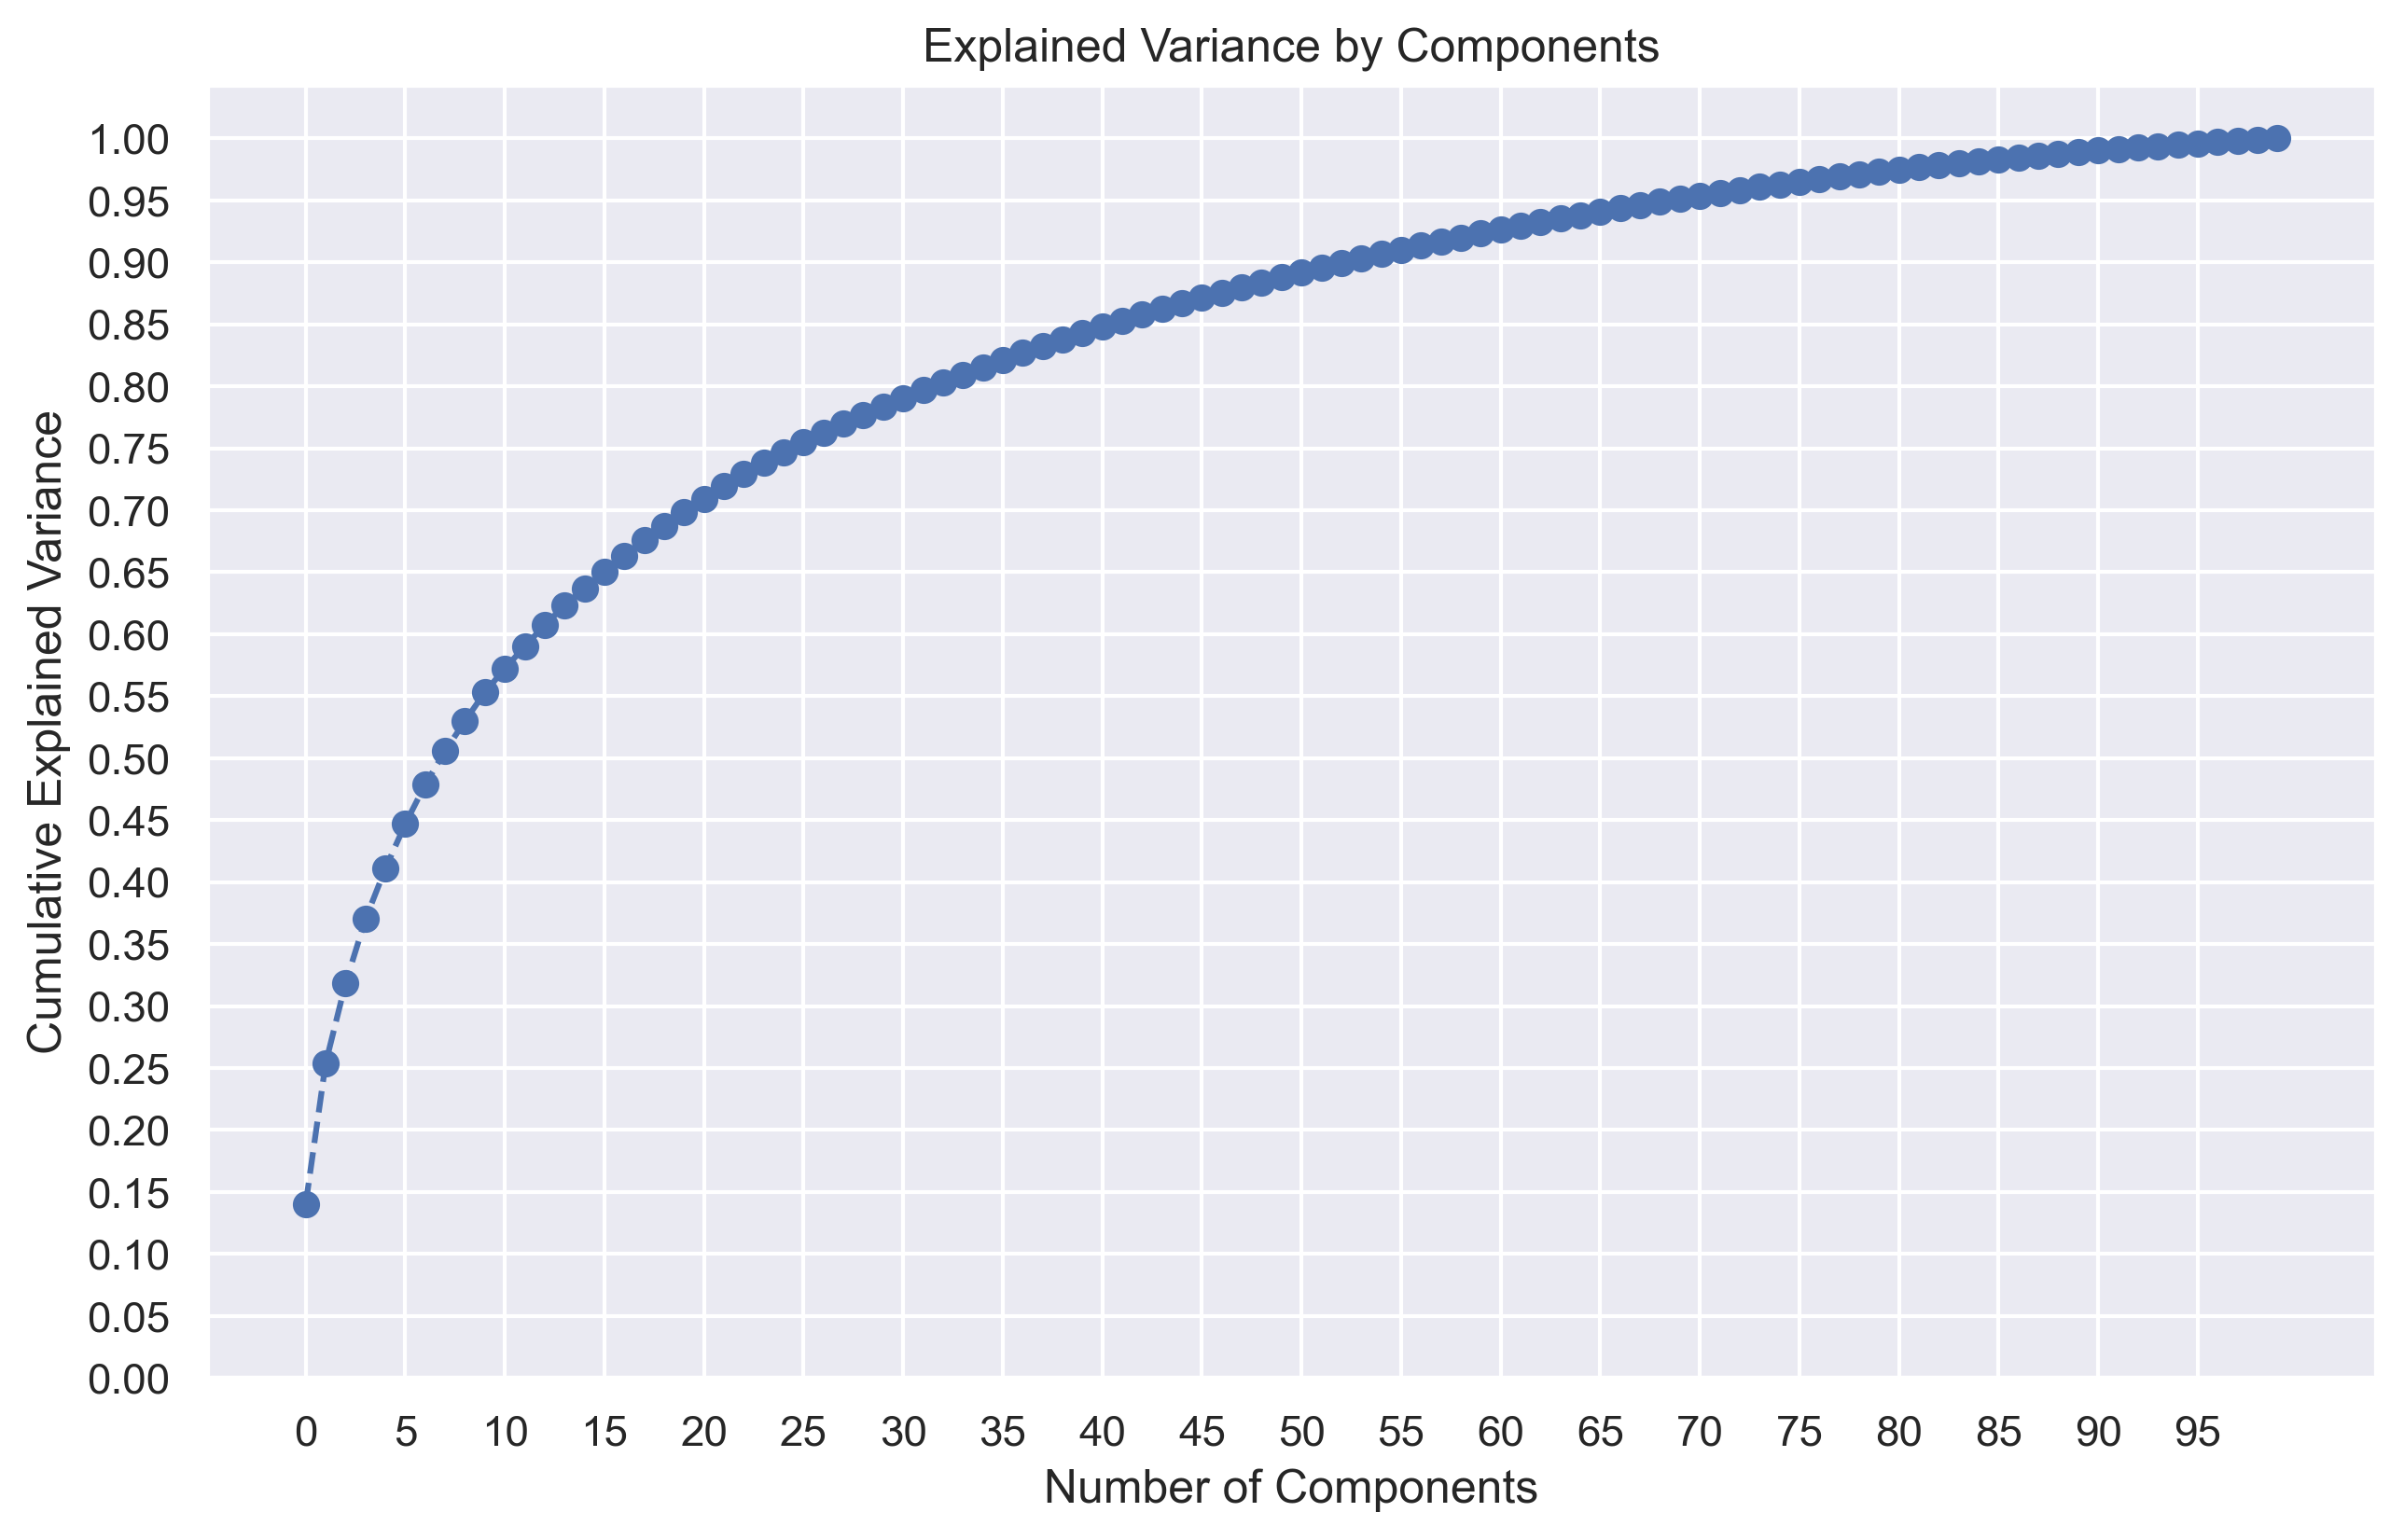

In [4]:
plt.clf()
plt.figure(figsize=(10,6), dpi=300)
plt.plot(range(0,100),pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(0, 100, 5))
plt.yticks(np.arange(0, 1.05, .05))
plt.show()

While Dr. Mac suggested values of 2,3,4, and 16, with a target PCA variance of 0.95. Other online sources suggest that 0.80 is good enough as well. The PCA variance only reaches >=0.80 at **32 components** while >=0.95 at **69 components** which is still a lot in the grand scheme of things.

Results (at 1e10):
- 2 = ~0.2500
- 3 = ~0.3250
- 4 = ~0.3750
- 16 = ~0.6500
- 32 = ~0.8000
- 42 = ~0.8500

The explanation behind the ideal the value of being as low as possible is that analysis will be exponential in size the higher the `n_components` is which could be explained by the sample code below.

```
n_components = 4
ctr = 0
for i in range(n_components):
    for j in range(i+1,n_components):
        print(ctr, i, j)
        ctr += 1
```

If it takes quite numerous components before reaching 0.80, then it might be the case that PCA is not suitable for the dataset.

- https://www.quora.com/How-do-I-check-if-my-dataset-is-suitable-for-PCA-Principal-component-analysis-in-ML-PCA-requires-data-to-be-linear-but-if-my-dataset-has-many-columns-how-do-I-check-that-it-is-linear-especially-when-my-output=
- https://medium.com/@khwabkalra1/unleashing-the-power-of-kernel-pca-bce7f4d2923d

In [5]:
delta_diff = None
def pca_benchmark(components:int):
    N_COMPONENTS = components
    pca = PCA(n_components=N_COMPONENTS, random_state=1)
    pca.fit(segmentation_std)
    scores_pca = pca.transform(segmentation_std)
    wcss = [] #Within Cluster Sum of Squares or WCSS (aka Inertia)
    silhouette = []
    davies = []
    for i in range(1,51):
        kmeans_pca = KMeans(n_clusters=i, random_state=1)
        kmeans_pca.fit(scores_pca)
        wcss.append(kmeans_pca.inertia_)
        if i < 2:
            silhouette.append(-1)
            davies.append(-1)
        else:  
            silhouette.append(silhouette_score(scores_pca, kmeans_pca.labels_, random_state=1))
            davies.append(davies_bouldin_score(scores_pca, kmeans_pca.labels_))
    prev_delta = None
    print("Cluster_Start_End, Intertia_Start_End, Delta, Delta_Diff, Silhouette, Davies")
    for i in range(len(wcss)-1):
        delta = wcss[i+1]-wcss[i]
        if prev_delta == None:
            prev_delta = delta
        print(f"{i:2d}-[{i+1:2d}], {wcss[i]:.4f}-{wcss[i+1]:.4f}, {delta:.4f}, {delta-prev_delta:.4f}, {silhouette[i]:.4f}, {davies[i]:.4f}")
        prev_delta = delta
    plt.clf()
    plt.figure(figsize=(10,5), dpi=300)
    plt.plot(range(1,51), wcss, marker='o', linestyle='--')
    plt.xlabel("Number of Clusters")
    plt.ylabel("WCSS")
    plt.xticks(np.arange(0, 55, 5))
    plt.title("K-Means with PCA Clustering")
    plt.savefig(f"pca_benchmark_{components}.png")
    plt.show()

Cluster_Start_End, Intertia_Start_End, Delta, Delta_Diff, Silhouette, Davies
 0-[ 1], 1312761.3118-890092.4935, -422668.8183, 0.0000, -1.0000, -1.0000
 1-[ 2], 890092.4935-494036.4725, -396056.0210, 26612.7972, 0.3786, 0.8637
 2-[ 3], 494036.4725-311032.0435, -183004.4290, 213051.5920, 0.5322, 0.5143
 3-[ 4], 311032.0435-190800.0707, -120231.9728, 62772.4563, 0.5393, 0.6767
 4-[ 5], 190800.0707-139737.5093, -51062.5615, 69169.4113, 0.5715, 0.5308
 5-[ 6], 139737.5093-114894.8538, -24842.6555, 26219.9060, 0.5411, 0.7260
 6-[ 7], 114894.8538-90555.6387, -24339.2151, 503.4404, 0.5186, 0.7294
 7-[ 8], 90555.6387-81168.4738, -9387.1649, 14952.0502, 0.5428, 0.7042
 8-[ 9], 81168.4738-73914.1785, -7254.2953, 2132.8696, 0.5325, 0.7489
 9-[10], 73914.1785-68665.8396, -5248.3389, 2005.9565, 0.5268, 0.7709
10-[11], 68665.8396-64108.5825, -4557.2571, 691.0818, 0.5217, 0.7673
11-[12], 64108.5825-59707.4472, -4401.1353, 156.1218, 0.5254, 0.7762
12-[13], 59707.4472-56378.9232, -3328.5240, 1072.6112, 

<Figure size 640x480 with 0 Axes>

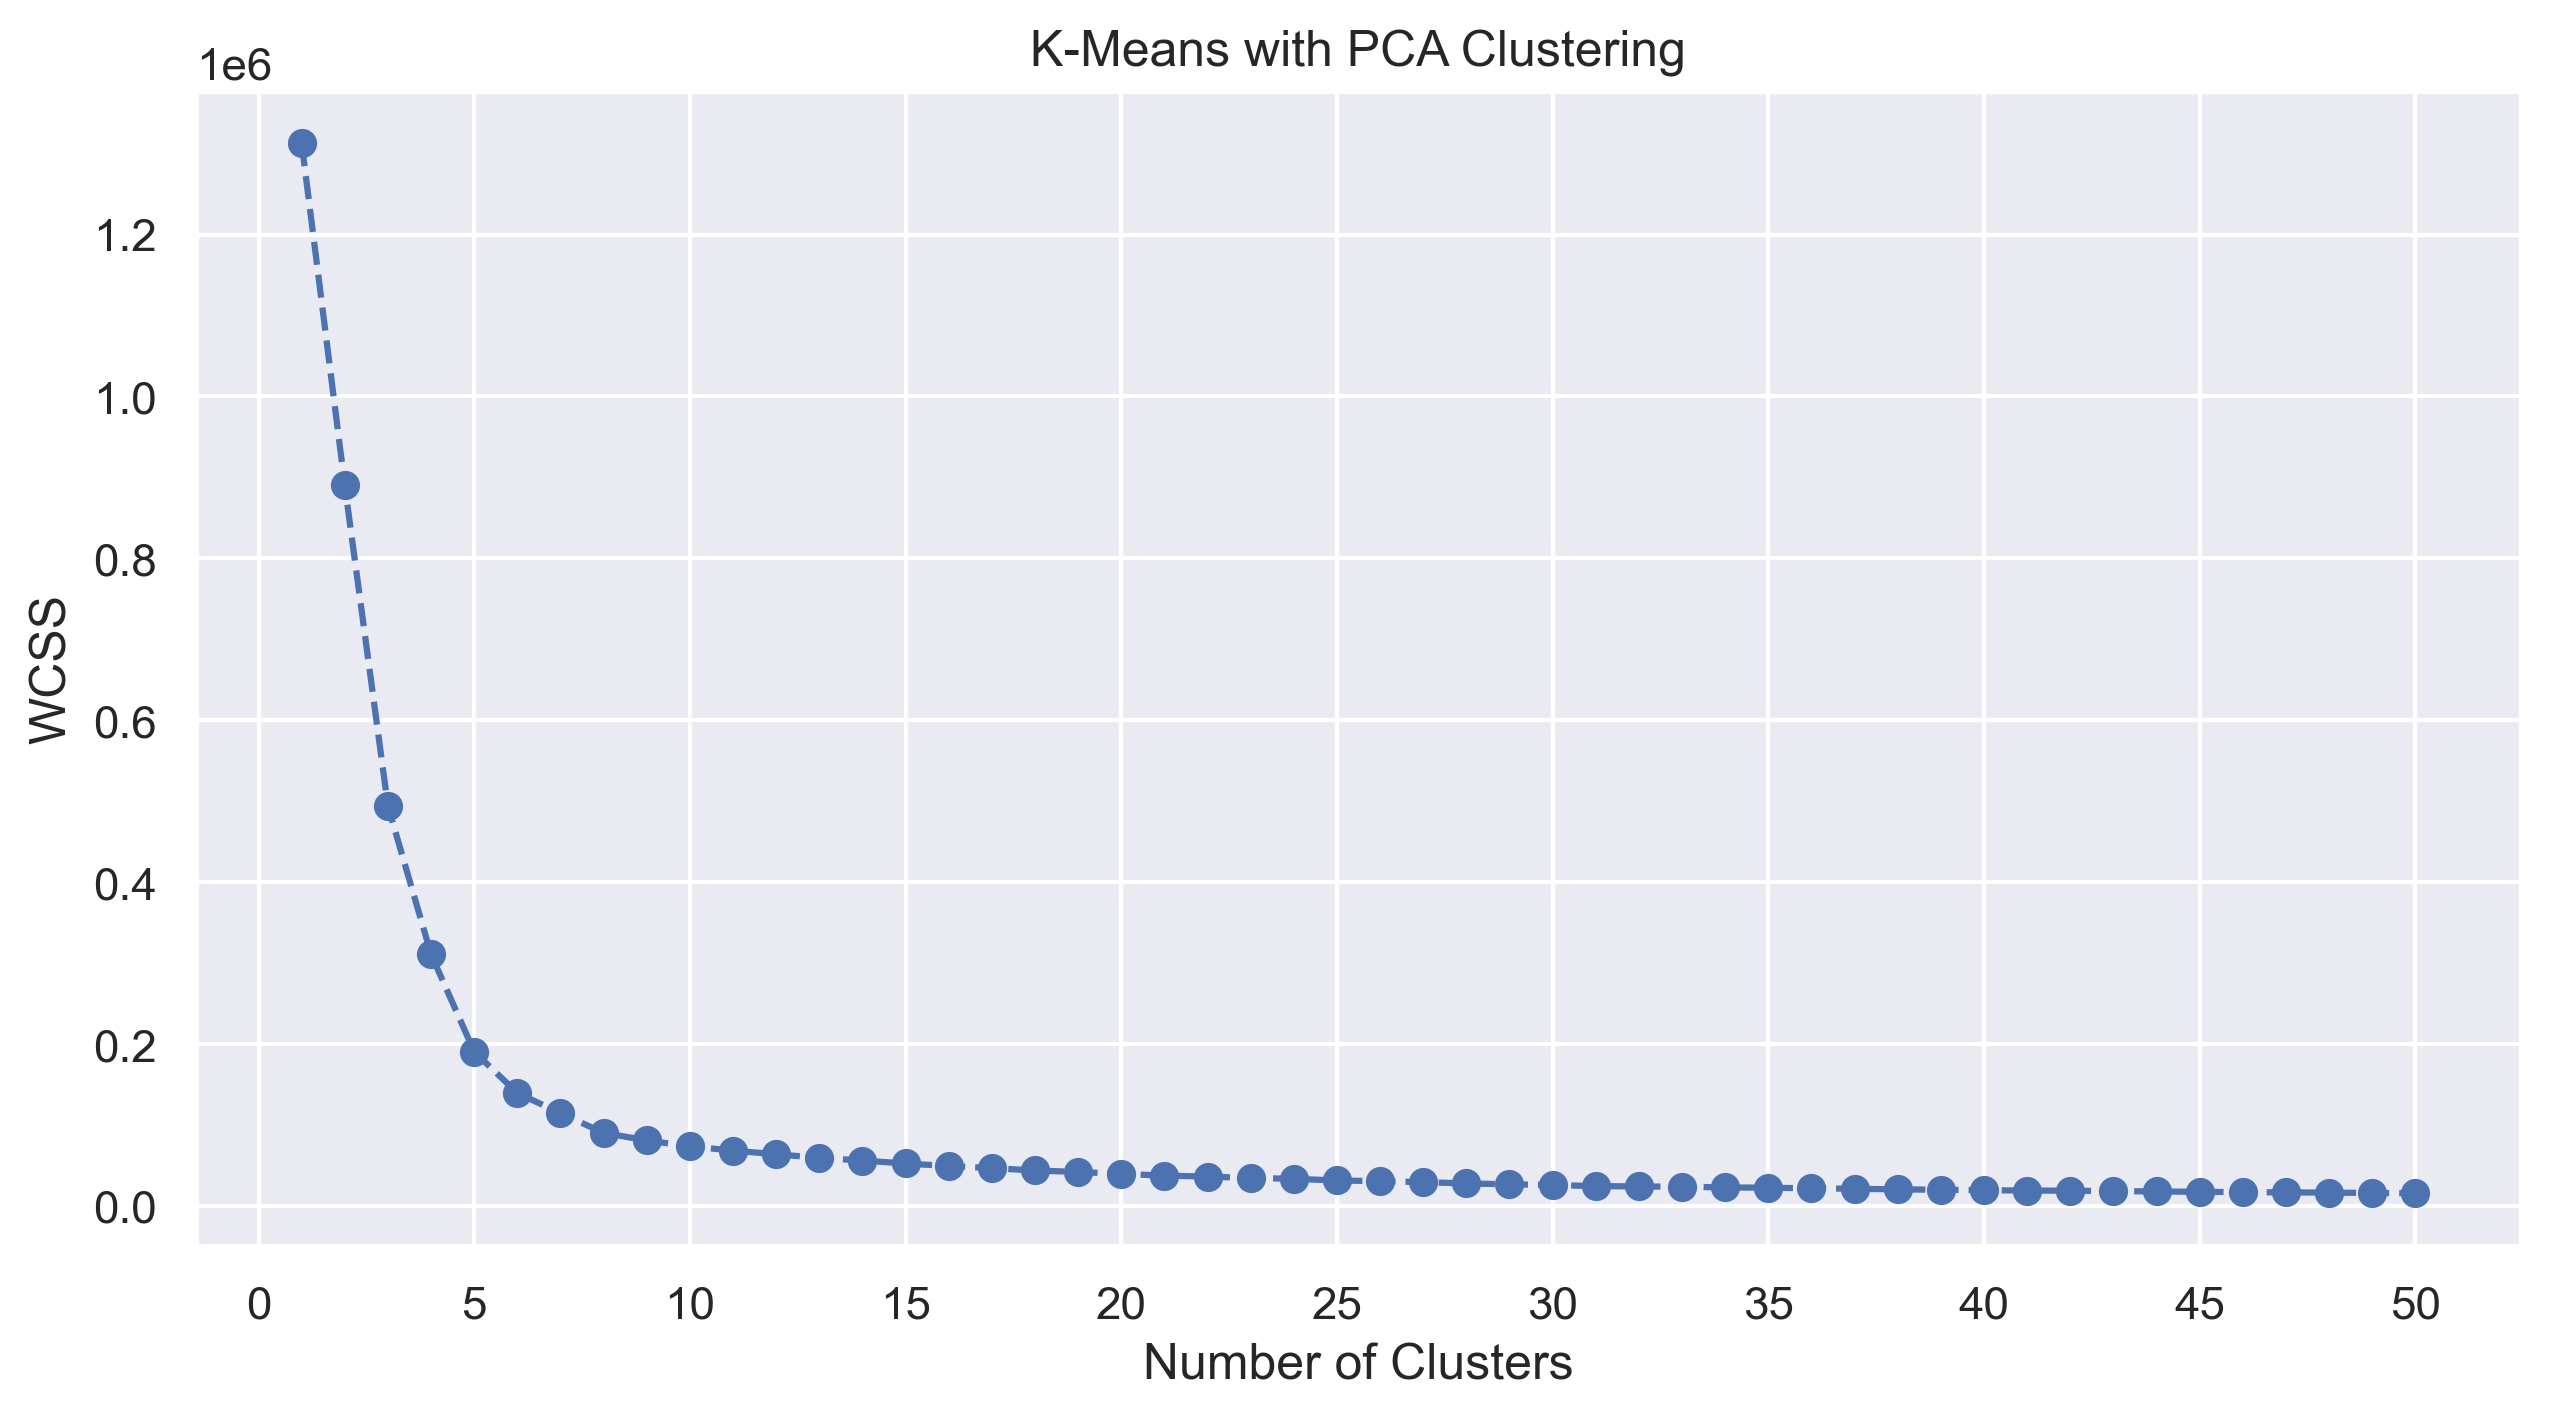

In [6]:
pca_benchmark(3)

In [7]:
pca_benchmark(4)

KeyboardInterrupt: 

In [ ]:
pca_benchmark(8)

In [ ]:
pca_benchmark(16)

In [ ]:
pca_benchmark(32)

In [ ]:
pca_benchmark(69)

In [ ]:
# def kmeans_test(CLUSTERS:int, df):
#     kmeans = KMeans(n_clusters = CLUSTERS, random_state=1)
#     kmeans.fit(df)
#     silhouette = silhouette_score(df, kmeans.labels_, random_state=1)
#     davies_bouldin = davies_bouldin_score(df, kmeans.labels_)
#     print(f"Silhouette Score: {silhouette:.4f}")
#     print(f"Davies Bouldin: {davies_bouldin:.4f}\n")
#     return kmeans

# # As per PCA WCSS
# k7 = kmeans_test(7, scores_pca)

# CLUSTERS = 7